# Set up environment

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import torchvision.transforms as transforms

In [2]:
!pip install -r https://raw.githubusercontent.com/caochengrui/Object_Classification_and_Localiztion_on_Emoji_Dataset/refs/heads/main/PyTorch/requirements.txt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


# Set Constant Parameter

In [ ]:
IMAGE_SIZE = 144
EMOJI_SIZE = 52
NUM_CLASSES = 9
NUM_SAMPLES = 8000
TRAIN_SPLIT = 0.8

# Download and Visualize Data

In [ ]:
!wget -q https://github.com/caochengrui/Object_Classification_and_Localiztion/raw/refs/heads/main/Dataset/openmoji-72x72-color.zip
!mkdir -p emojis
!unzip -qo openmoji-72x72-color.zip -d ./emojis

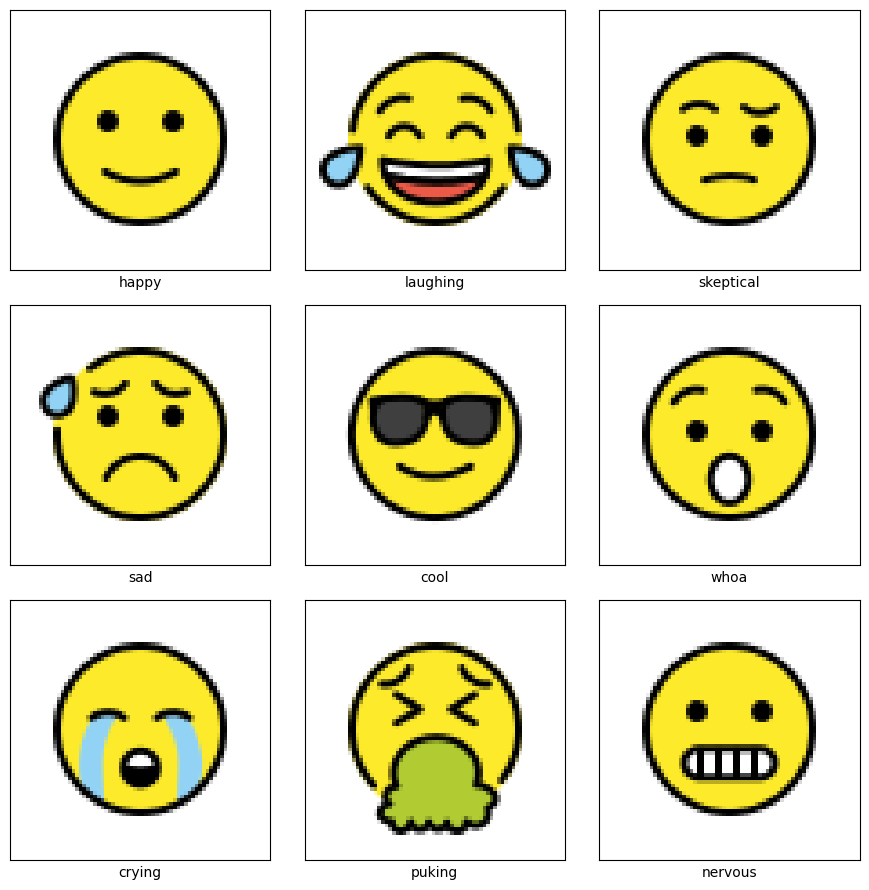

In [ ]:
emojis = {
    0: {'name': 'happy', 'file': '1F642.png'},
    1: {'name': 'laughing', 'file': '1F602.png'},
    2: {'name': 'skeptical', 'file': '1F928.png'},
    3: {'name': 'sad', 'file': '1F630.png'},
    4: {'name': 'cool', 'file': '1F60E.png'},
    5: {'name': 'whoa', 'file': '1F62F.png'},
    6: {'name': 'crying', 'file': '1F62D.png'},
    7: {'name': 'puking', 'file': '1F92E.png'},
    8: {'name': 'nervous', 'file': '1F62C.png'}
}


plt.figure(figsize=(9, 9))
for i, (j, e) in enumerate(emojis.items()):
    plt.subplot(3, 3, i + 1)
    img_path = os.path.join('emojis', e['file'])
    plt.imshow(Image.open(img_path))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

# Create Examples

In [ ]:
for class_id, values in emojis.items():
    png_file = Image.open(os.path.join('emojis', values['file'])).convert('RGBA')
    png_file.load()
    new_file = Image.new("RGB", png_file.size, (255, 255, 255))
    new_file.paste(png_file, mask=png_file.split()[3])
    emojis[class_id]['image'] = new_file

In [ ]:
def create_example():
    class_id = random.randint(0, NUM_CLASSES - 1)

    image = Image.new('RGB', (IMAGE_SIZE, IMAGE_SIZE), (255, 255, 255))
    row = random.randint(0, IMAGE_SIZE/2)
    col = random.randint(0, IMAGE_SIZE/2)

    image.paste(emojis[class_id]['image'], (col, row))

    norm_row = (row + 10) / IMAGE_SIZE
    norm_col = (col + 10) / IMAGE_SIZE

    return np.array(image), class_id, [norm_row, norm_col]

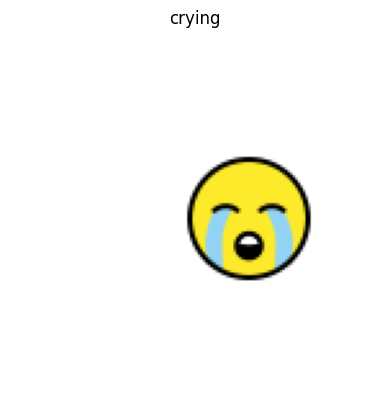

In [ ]:
image, class_id, coords = create_example()
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.axis('off')
plt.show()

# Plot Bounding Boxes

In [ ]:
def plot_bounding_box(image, gt_coords, pred_coords=None, norm=False):
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image.astype('uint8'))
    draw = ImageDraw.Draw(image)

    gt_row, gt_col = gt_coords
    if norm:
        gt_row *= IMAGE_SIZE
        gt_col *= IMAGE_SIZE

    draw.rectangle([gt_col, gt_row, gt_col + EMOJI_SIZE, gt_row + EMOJI_SIZE],
                   outline='green', width=3)


    if pred_coords is not None:
        pred_row, pred_col = pred_coords
        if norm:
            pred_row *= IMAGE_SIZE
            pred_col *= IMAGE_SIZE

        draw.rectangle([pred_col, pred_row, pred_col + EMOJI_SIZE, pred_row + EMOJI_SIZE],
                       outline='red', width=3)

    return image

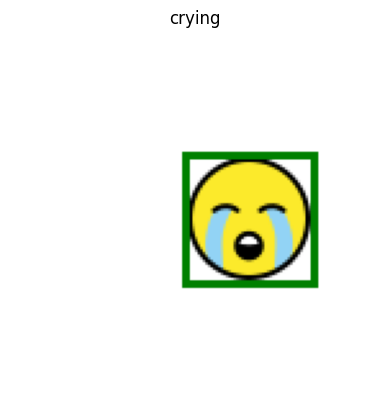

In [ ]:
image_with_box = plot_bounding_box(image, gt_coords=coords, norm=True)
plt.imshow(image_with_box)
plt.title(emojis[class_id]['name'])
plt.axis('off')
plt.show()

# Data Generator

In [ ]:
def generate_dataset(num_samples):
    images = []
    class_labels = []
    coord_labels = []

    for _ in tqdm(range(num_samples), desc="Generating data"):
        img, class_label, coords = create_example()
        images.append(img)
        class_labels.append(class_label)
        coord_labels.append(coords)

    images = np.array(images, dtype=np.float32) / 255.0  # 归一化到 [0,1]
    class_labels = np.array(class_labels, dtype=np.int64)
    coord_labels = np.array(coord_labels, dtype=np.float32)

    return images, class_labels, coord_labels

Generating data: 100%|██████████| 16/16 [00:00<00:00, 3387.97it/s]


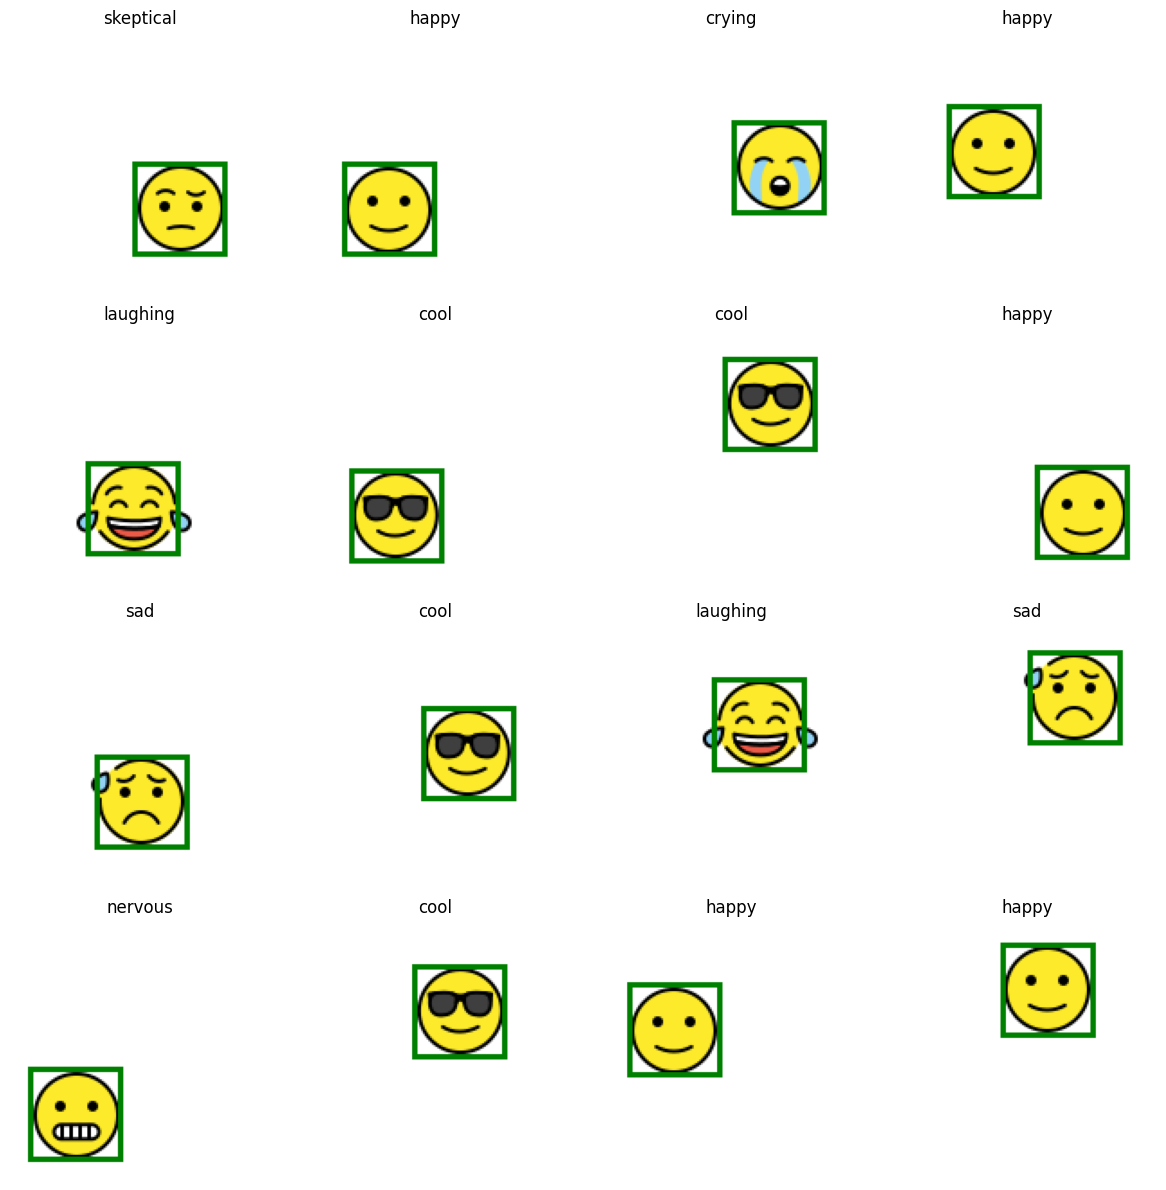

In [ ]:
sample_images, sample_class_labels, sample_coord_labels = generate_dataset(16)

def display_batch(images, class_labels, coord_labels, num_samples=16):
    grid_size = int(np.ceil(np.sqrt(num_samples)))
    plt.figure(figsize=(grid_size * 3, grid_size * 3))

    for i in range(num_samples):
        img = (images[i] * 255).astype('uint8')
        class_id = class_labels[i]
        coord = coord_labels[i]

        img_with_box = plot_bounding_box(img, gt_coords=coord, norm=True)

        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(img_with_box)
        plt.title(emojis[class_id]['name'])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_batch(sample_images, sample_class_labels, sample_coord_labels, num_samples=16)

In [ ]:
images, class_labels, coord_labels = generate_dataset(NUM_SAMPLES)

split_idx = int(NUM_SAMPLES * TRAIN_SPLIT)

x_train, x_test = images[:split_idx], images[split_idx:]
y_train_class, y_test_class = class_labels[:split_idx], class_labels[split_idx:]
y_train_coord, y_test_coord = coord_labels[:split_idx], coord_labels[split_idx:]

x_train = torch.tensor(x_train).permute(0, 3, 1, 2)  # 转换为 (N, C, H, W)
x_test = torch.tensor(x_test).permute(0, 3, 1, 2)

y_train_class = torch.tensor(y_train_class)
y_test_class = torch.tensor(y_test_class)

y_train_coord = torch.tensor(y_train_coord)
y_test_coord = torch.tensor(y_test_coord)

train_dataset = TensorDataset(x_train, y_train_class, y_train_coord)
test_dataset = TensorDataset(x_test, y_test_class, y_test_coord)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Generating data: 100%|██████████| 8000/8000 [00:00<00:00, 8369.62it/s]


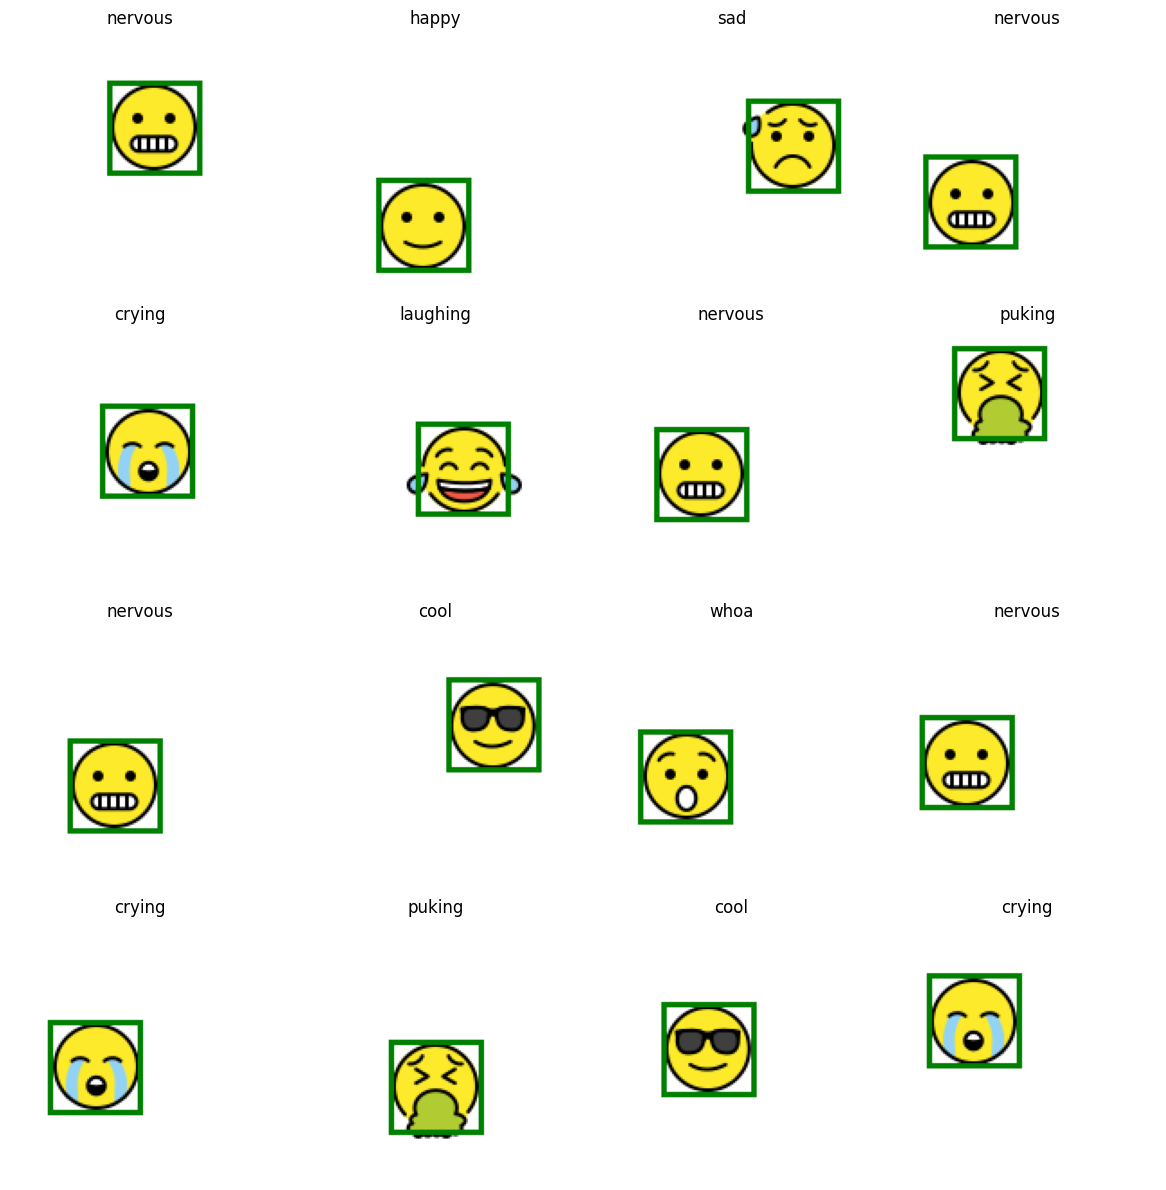

In [ ]:
def visualize_batch(loader, num_samples=16):
    data_iter = iter(loader)
    images, class_labels, coord_labels = next(data_iter)
    images = images.numpy().transpose(0, 2, 3, 1)
    class_labels = class_labels.numpy()
    coord_labels = coord_labels.numpy()
    display_batch(images, class_labels, coord_labels, num_samples=num_samples)

visualize_batch(train_loader, num_samples=16)

# Custom IoU(Intersection over Union)

In [ ]:
class IoU:
    def __init__(self):
        self.reset()

    def reset(self):
        self.total_iou = 0.0
        self.num_examples = 0

    def update(self, y_true, y_pred):
        gt_x1 = y_true[:, 1] * IMAGE_SIZE
        gt_y1 = y_true[:, 0] * IMAGE_SIZE
        gt_x2 = gt_x1 + EMOJI_SIZE
        gt_y2 = gt_y1 + EMOJI_SIZE

        pred_x1 = y_pred[:, 1] * IMAGE_SIZE
        pred_y1 = y_pred[:, 0] * IMAGE_SIZE
        pred_x2 = pred_x1 + EMOJI_SIZE
        pred_y2 = pred_y1 + EMOJI_SIZE

        inter_x1 = torch.max(gt_x1, pred_x1)
        inter_y1 = torch.max(gt_y1, pred_y1)
        inter_x2 = torch.min(gt_x2, pred_x2)
        inter_y2 = torch.min(gt_y2, pred_y2)

        inter_w = (inter_x2 - inter_x1).clamp(min=0)
        inter_h = (inter_y2 - inter_y1).clamp(min=0)
        inter_area = inter_w * inter_h

        gt_area = (gt_x2 - gt_x1) * (gt_y2 - gt_y1)
        pred_area = (pred_x2 - pred_x1) * (pred_y2 - pred_y1)
        union_area = gt_area + pred_area - inter_area

        iou = torch.where(union_area > 0, inter_area / union_area, torch.zeros_like(union_area))

        self.total_iou += iou.sum().item()
        self.num_examples += y_true.size(0)

    def compute(self):
        if self.num_examples == 0:
            return 0
        return self.total_iou / self.num_examples

# Model

In [ ]:
class ObjectClassificationLocalizationModel(nn.Module):
    def __init__(self, num_classes=9):
        super(ObjectClassificationLocalizationModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(256 * 2 * 2, 256),
            nn.ReLU()
        )

        self.classifier = nn.Linear(256, num_classes)
        self.regressor = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.fc(x)
        class_output = self.classifier(x)
        coord_output = self.regressor(x)
        return class_output, coord_output

model = ObjectClassificationLocalizationModel(NUM_CLASSES).to(device)
print(model)

ObjectClassificationLocalizationModel(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): MaxPool2d(k

# Train

In [ ]:
criterion_class = nn.CrossEntropyLoss()
criterion_coord = nn.MSELoss()

optimizer_shared = optim.Adam(list(model.features.parameters()) + list(model.fc.parameters()), lr=0.001)

optimizer_class = optim.Adam(model.classifier.parameters(), lr=0.001)

optimizer_coord = optim.Adam(model.regressor.parameters(), lr=0.001)

scheduler_class = optim.lr_scheduler.ReduceLROnPlateau(optimizer_class, mode='max', factor=0.5, patience=3, verbose=True, min_lr=1e-6)
scheduler_coord = optim.lr_scheduler.ReduceLROnPlateau(optimizer_coord, mode='max', factor=0.5, patience=3, verbose=True, min_lr=1e-6)


early_stop_patience = 7

num_epochs = 50
best_val_acc = 0.0
best_val_iou = 0.0
epochs_no_improve = 0

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_predictions(model, loader, emojis, device, num_samples=4):
    model.eval()
    images, class_labels, coord_labels = next(iter(loader))
    images = images.to(device)
    class_labels = class_labels.to(device)
    coord_labels = coord_labels.to(device)

    with torch.no_grad():
        class_preds, coord_preds = model(images)
        class_pred_labels = torch.argmax(class_preds, dim=1)

    images = images.cpu().numpy().transpose(0, 2, 3, 1)
    class_labels = class_labels.cpu().numpy()
    class_pred_labels = class_pred_labels.cpu().numpy()
    coord_labels = coord_labels.cpu().numpy()
    coord_preds = coord_preds.cpu().numpy()

    fig, axs = plt.subplots(1, num_samples, figsize=(4*num_samples, 4))
    for i in range(num_samples):
        img = (images[i] * 255).astype('uint8')
        true_class = class_labels[i]
        pred_class = class_pred_labels[i]
        true_coord = coord_labels[i]
        pred_coord = coord_preds[i]

        img_with_boxes = plot_bounding_box(img, gt_coords=true_coord, pred_coords=pred_coord, norm=True)

        if true_class == pred_class:
            title_color = 'green'
        else:
            title_color = 'red'

        axs[i].imshow(img_with_boxes)
        axs[i].set_title(f"T: {emojis[true_class]['name']}\nP: {emojis[pred_class]['name']}", color=title_color)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

Epoch 1/50 - Validation: 100%|██████████| 100/100 [00:01<00:00, 59.01it/s]


Epoch [1/50]
Train Class Loss: 0.3336 | Train Coord Loss: 0.0033 | Train Acc: 0.8720 | Train IoU: 0.6628
Val Class Loss: 2.4992 | Val Coord Loss: 0.0063 | Val Acc: 0.5981 | Val IoU: 0.5649


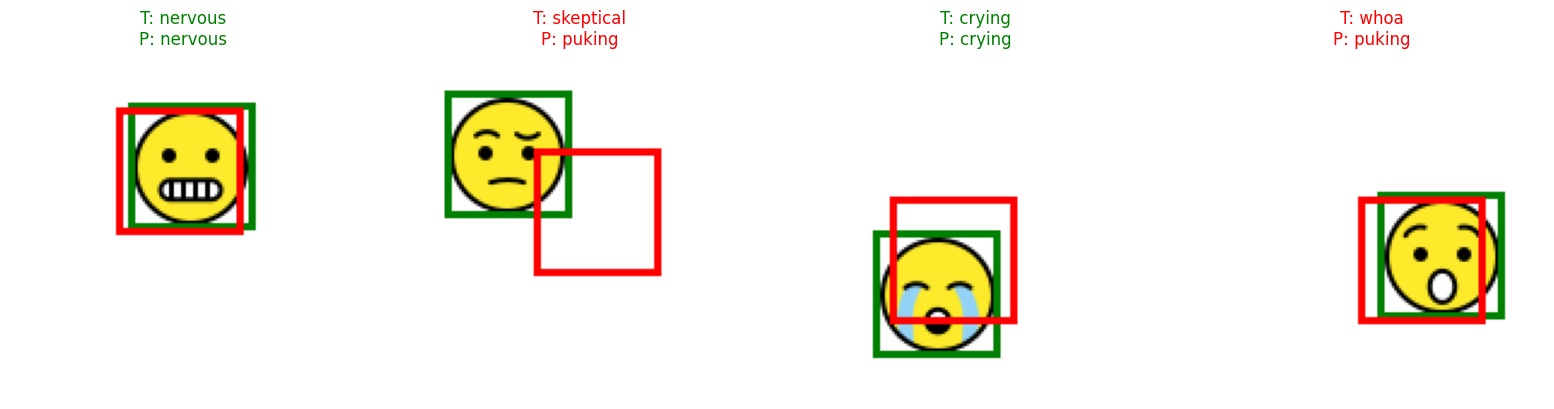

Epoch 2/50 - Validation: 100%|██████████| 100/100 [00:01<00:00, 86.75it/s]



Epoch [2/50]
Train Class Loss: 0.0362 | Train Coord Loss: 0.0014 | Train Acc: 0.9912 | Train IoU: 0.7476
Val Class Loss: 0.0000 | Val Coord Loss: 0.0007 | Val Acc: 1.0000 | Val IoU: 0.8110


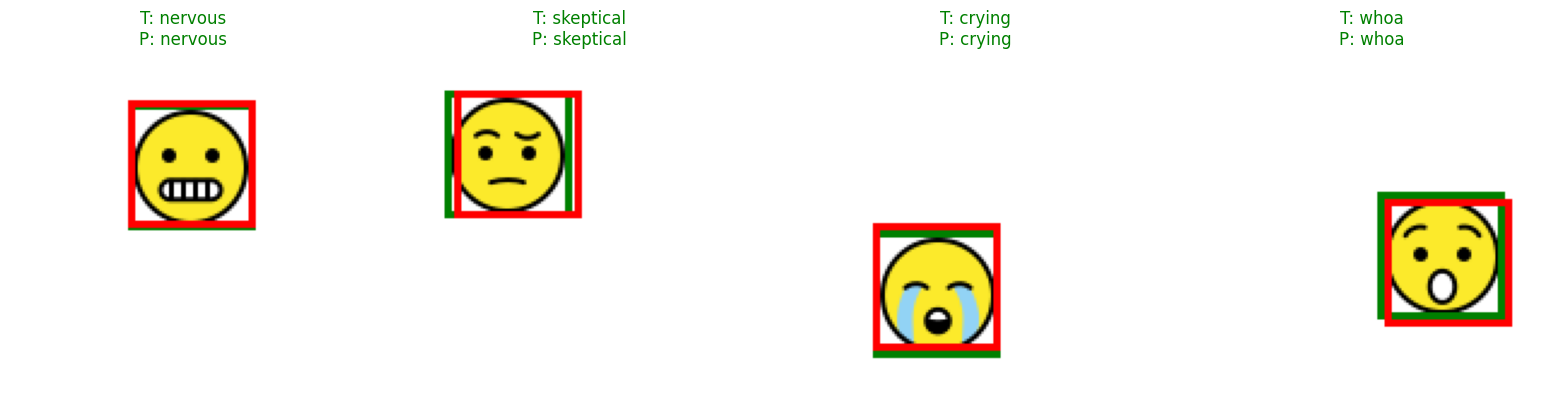

Epoch 3/50 - Validation: 100%|██████████| 100/100 [00:01<00:00, 78.82it/s]


Epoch [3/50]
Train Class Loss: 0.0532 | Train Coord Loss: 0.0011 | Train Acc: 0.9900 | Train IoU: 0.7767
Val Class Loss: 0.0002 | Val Coord Loss: 0.0009 | Val Acc: 1.0000 | Val IoU: 0.7904


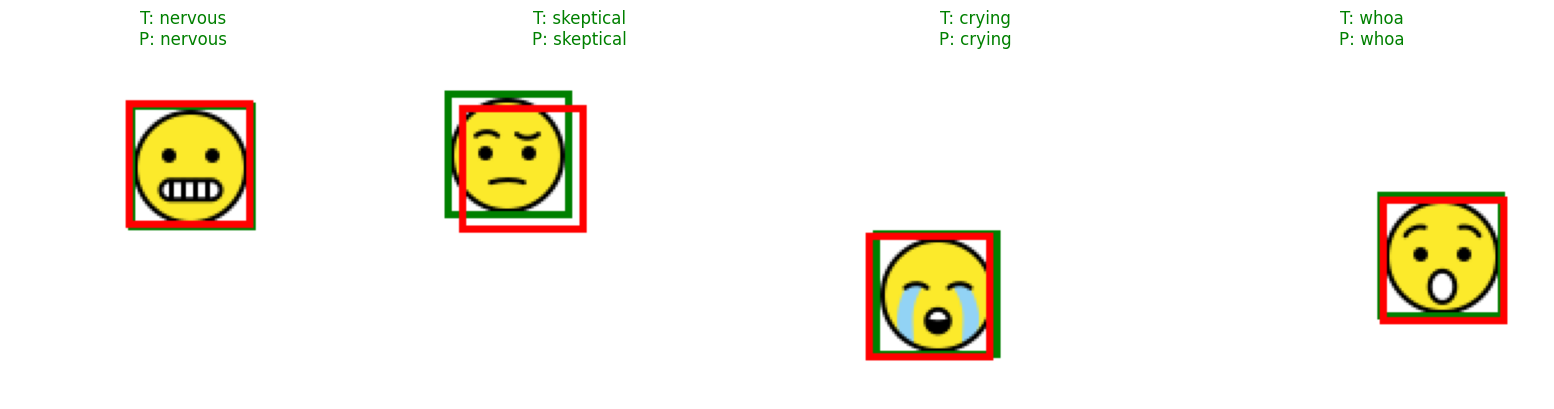

Epoch 4/50 - Validation: 100%|██████████| 100/100 [00:01<00:00, 57.05it/s]


Epoch [4/50]
Train Class Loss: 0.0218 | Train Coord Loss: 0.0012 | Train Acc: 0.9931 | Train IoU: 0.7623
Val Class Loss: 0.0002 | Val Coord Loss: 0.0005 | Val Acc: 1.0000 | Val IoU: 0.8253


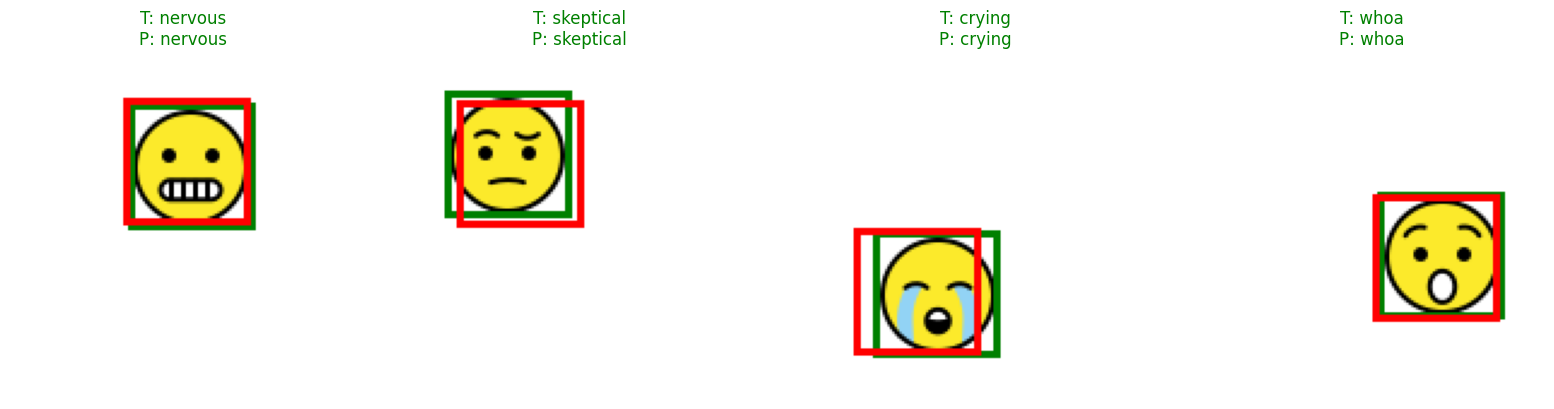

Epoch 5/50 - Validation: 100%|██████████| 100/100 [00:01<00:00, 85.64it/s]


Epoch [5/50]
Train Class Loss: 0.0481 | Train Coord Loss: 0.0011 | Train Acc: 0.9898 | Train IoU: 0.7762
Val Class Loss: 3.8134 | Val Coord Loss: 0.0158 | Val Acc: 0.7481 | Val IoU: 0.4236


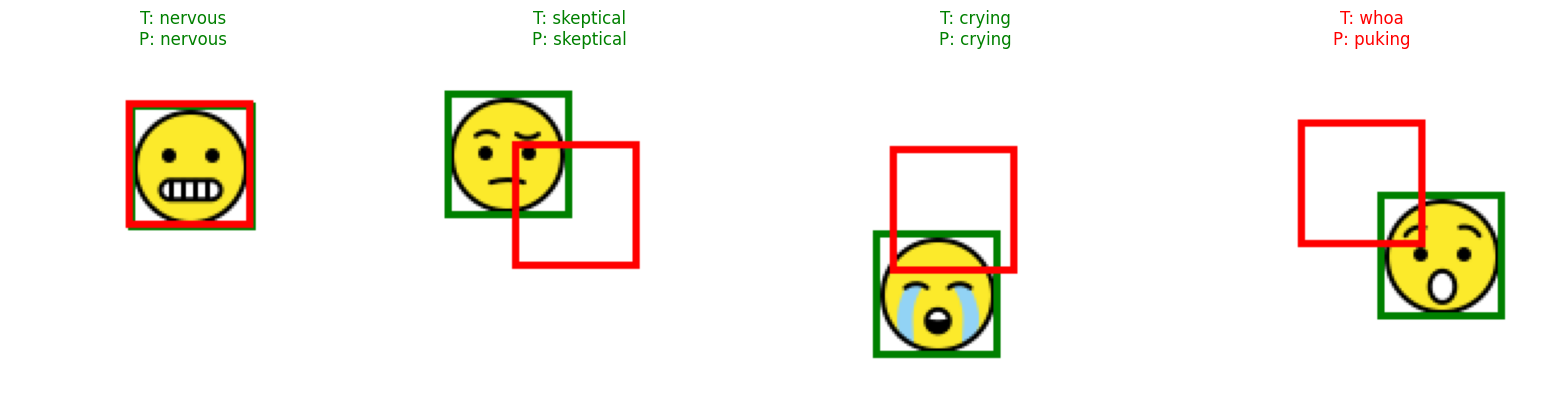

Epoch 6/50 - Validation: 100%|██████████| 100/100 [00:01<00:00, 82.67it/s]


Epoch [6/50]
Train Class Loss: 0.0220 | Train Coord Loss: 0.0012 | Train Acc: 0.9955 | Train IoU: 0.7605
Val Class Loss: 0.0000 | Val Coord Loss: 0.0010 | Val Acc: 1.0000 | Val IoU: 0.7793


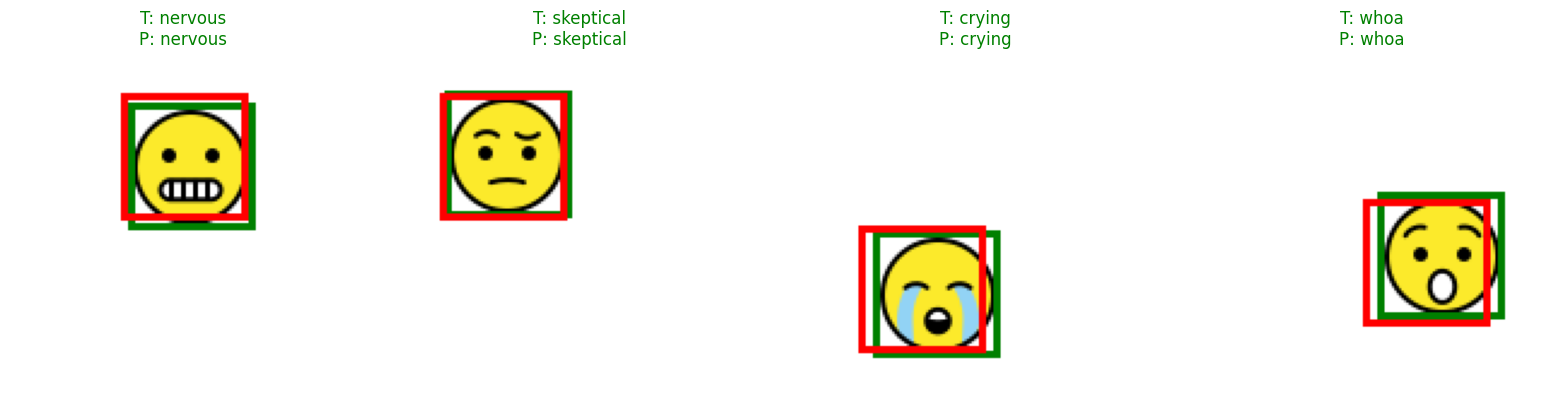

Epoch 7/50 - Validation: 100%|██████████| 100/100 [00:01<00:00, 82.71it/s]


Epoch [7/50]
Train Class Loss: 0.0088 | Train Coord Loss: 0.0008 | Train Acc: 0.9978 | Train IoU: 0.7976
Val Class Loss: 0.0000 | Val Coord Loss: 0.0005 | Val Acc: 1.0000 | Val IoU: 0.8365


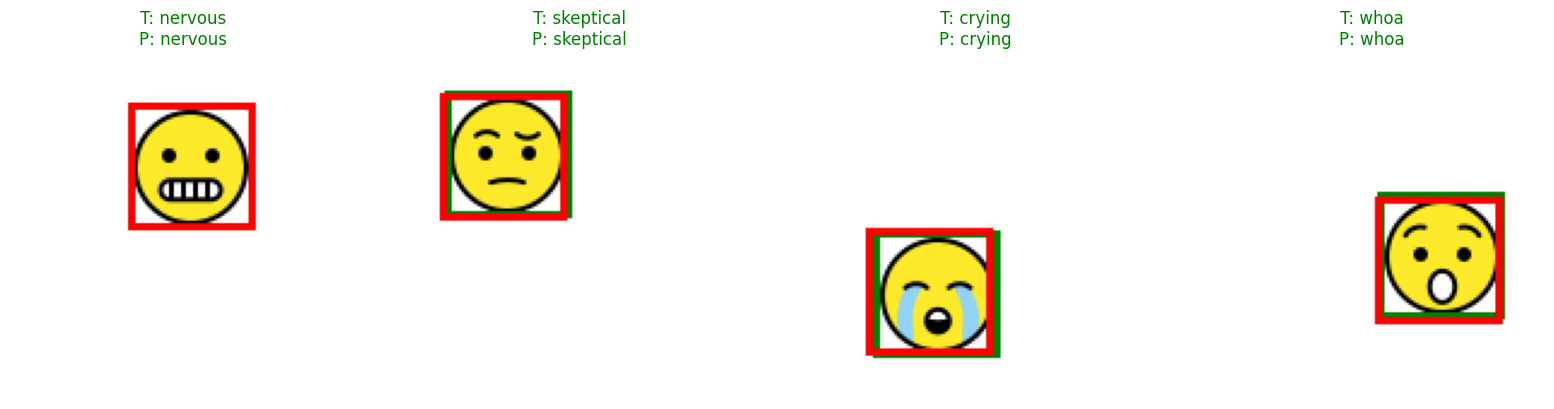

Epoch 8/50 - Validation: 100%|██████████| 100/100 [00:01<00:00, 83.92it/s]


Epoch [8/50]
Train Class Loss: 0.0004 | Train Coord Loss: 0.0006 | Train Acc: 1.0000 | Train IoU: 0.8229
Val Class Loss: 0.0000 | Val Coord Loss: 0.0004 | Val Acc: 1.0000 | Val IoU: 0.8403


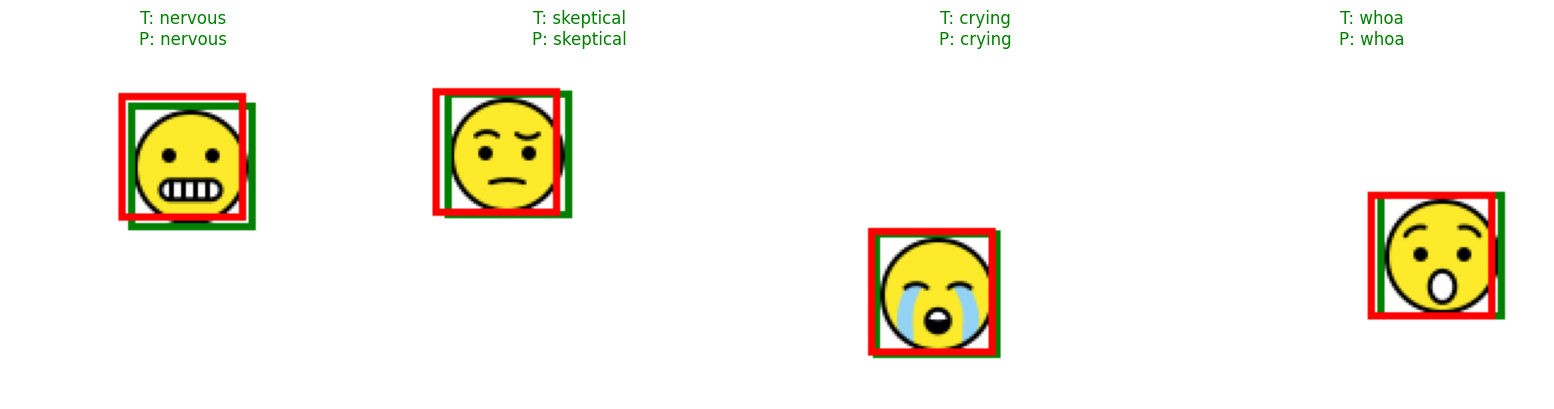

Epoch 9/50 - Validation: 100%|██████████| 100/100 [00:01<00:00, 83.33it/s]


Epoch [9/50]
Train Class Loss: 0.0363 | Train Coord Loss: 0.0009 | Train Acc: 0.9934 | Train IoU: 0.7882
Val Class Loss: 0.0000 | Val Coord Loss: 0.0005 | Val Acc: 1.0000 | Val IoU: 0.8338


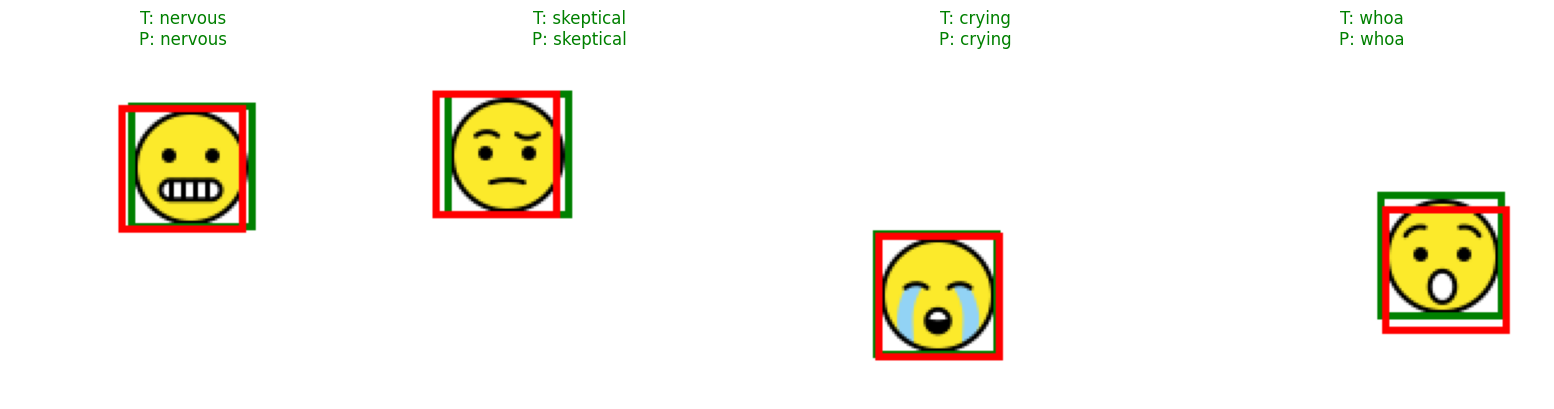

Epoch 10/50 - Validation: 100%|██████████| 100/100 [00:01<00:00, 55.09it/s]


Epoch [10/50]
Train Class Loss: 0.0163 | Train Coord Loss: 0.0008 | Train Acc: 0.9967 | Train IoU: 0.7943
Val Class Loss: 0.0001 | Val Coord Loss: 0.0006 | Val Acc: 1.0000 | Val IoU: 0.8176


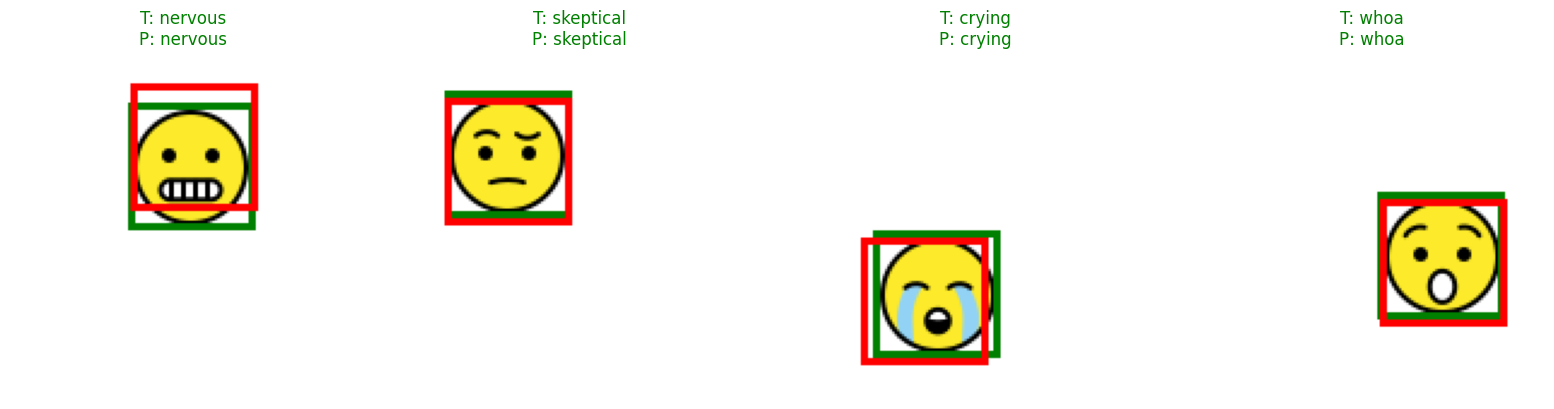

Epoch 11/50 - Validation: 100%|██████████| 100/100 [00:01<00:00, 60.42it/s]


Epoch [11/50]
Train Class Loss: 0.0059 | Train Coord Loss: 0.0006 | Train Acc: 0.9981 | Train IoU: 0.8186
Val Class Loss: 0.0001 | Val Coord Loss: 0.0009 | Val Acc: 1.0000 | Val IoU: 0.7850


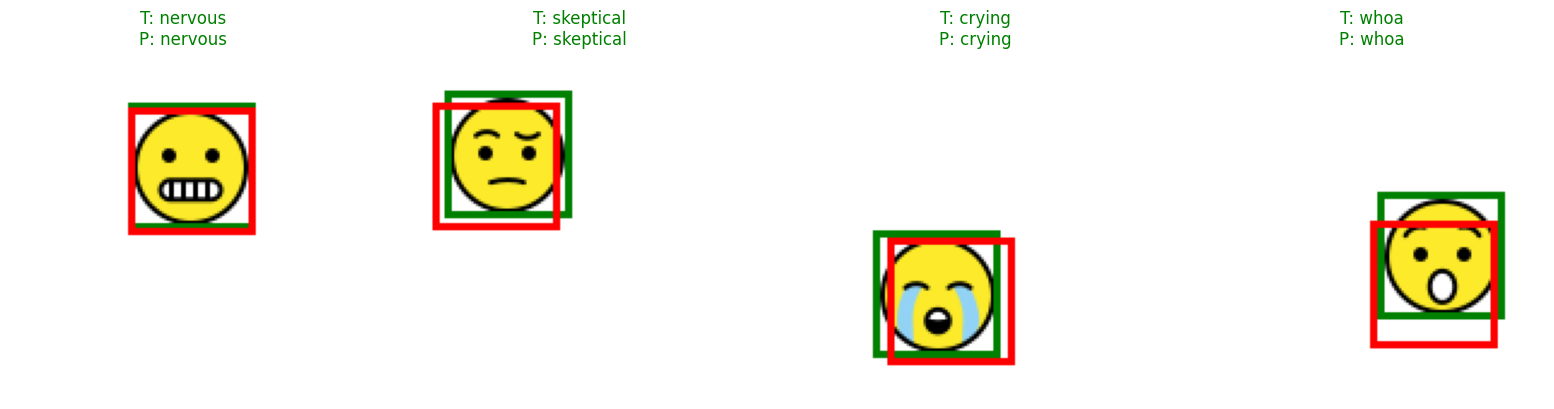

Epoch 12/50 - Validation: 100%|██████████| 100/100 [00:01<00:00, 79.21it/s]


Epoch [12/50]
Train Class Loss: 0.0001 | Train Coord Loss: 0.0005 | Train Acc: 1.0000 | Train IoU: 0.8285
Val Class Loss: 0.0000 | Val Coord Loss: 0.0003 | Val Acc: 1.0000 | Val IoU: 0.8617


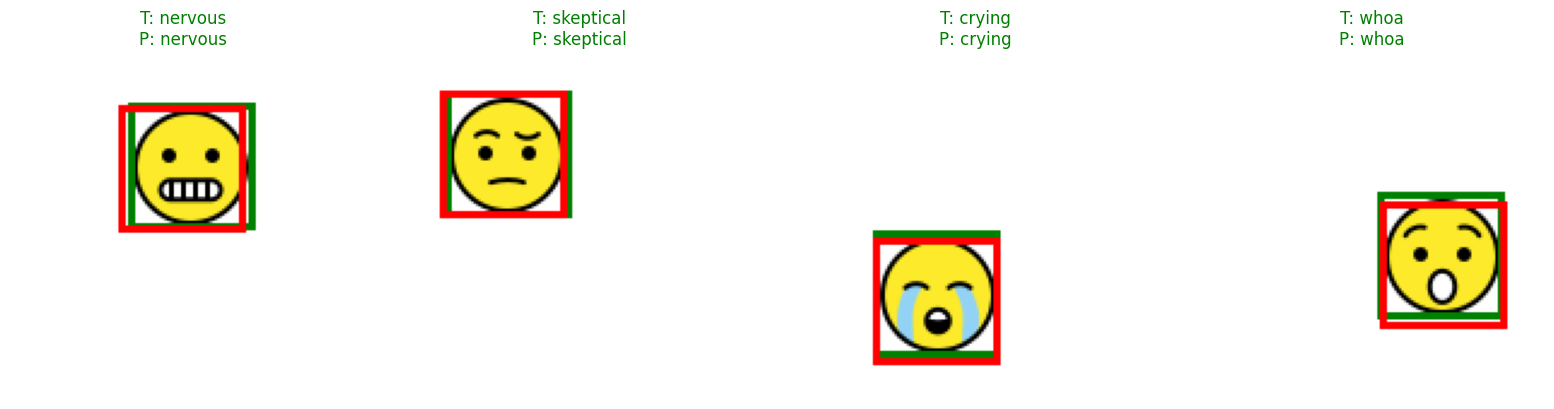

Epoch 13/50 - Validation: 100%|██████████| 100/100 [00:01<00:00, 82.76it/s]


Epoch [13/50]
Train Class Loss: 0.0000 | Train Coord Loss: 0.0004 | Train Acc: 1.0000 | Train IoU: 0.8529
Val Class Loss: 0.0000 | Val Coord Loss: 0.0003 | Val Acc: 1.0000 | Val IoU: 0.8701


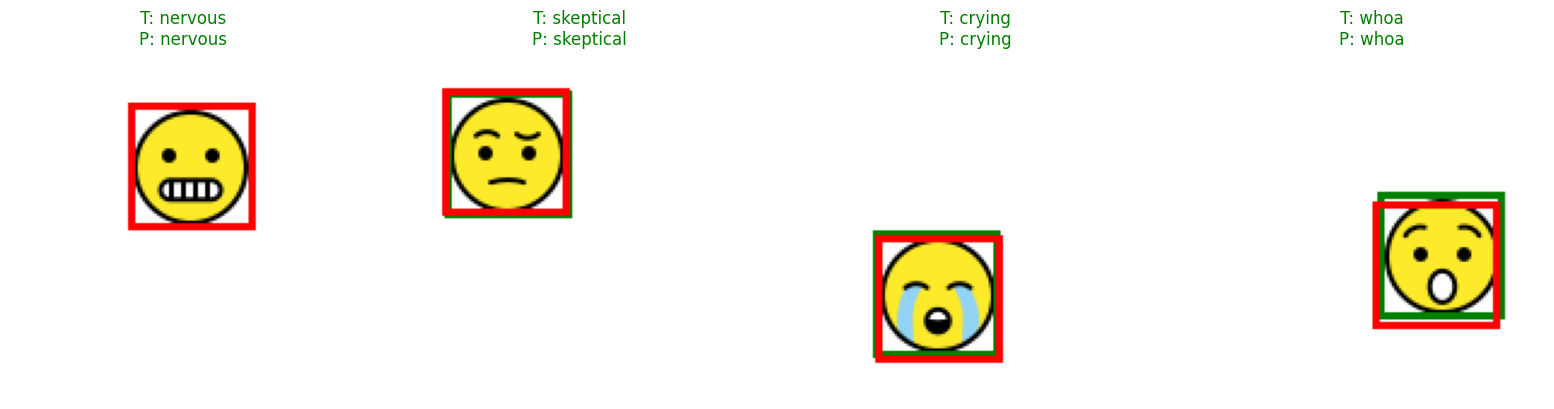

Epoch 14/50 - Validation: 100%|██████████| 100/100 [00:01<00:00, 80.55it/s]


Epoch [14/50]
Train Class Loss: 0.0000 | Train Coord Loss: 0.0003 | Train Acc: 1.0000 | Train IoU: 0.8634
Val Class Loss: 0.0000 | Val Coord Loss: 0.0002 | Val Acc: 1.0000 | Val IoU: 0.8915


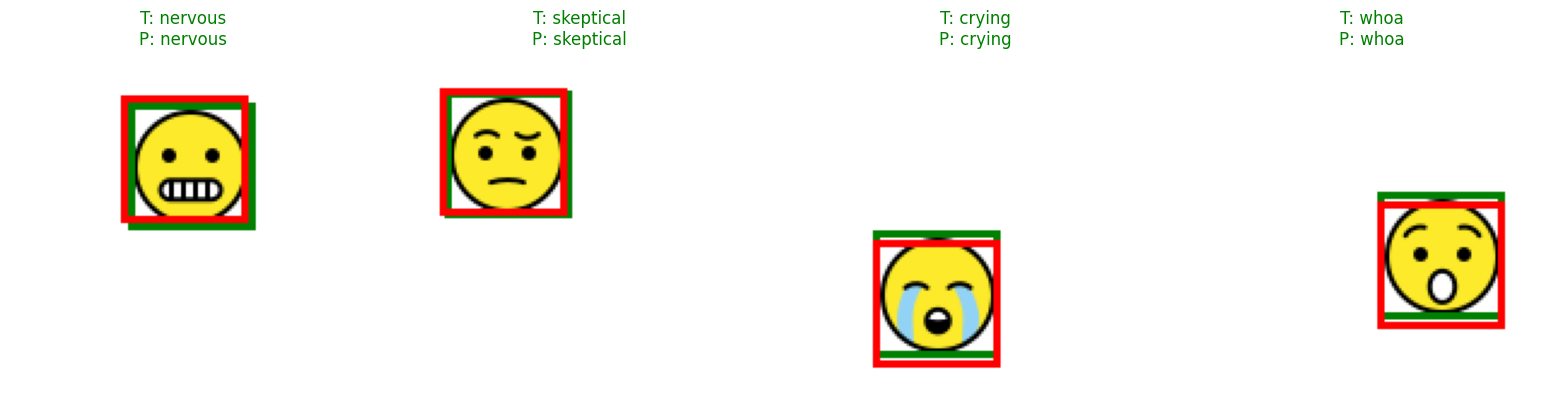

Epoch 15/50 - Validation: 100%|██████████| 100/100 [00:01<00:00, 81.23it/s]


Epoch [15/50]
Train Class Loss: 0.0000 | Train Coord Loss: 0.0003 | Train Acc: 1.0000 | Train IoU: 0.8733
Val Class Loss: 0.0000 | Val Coord Loss: 0.0003 | Val Acc: 1.0000 | Val IoU: 0.8643


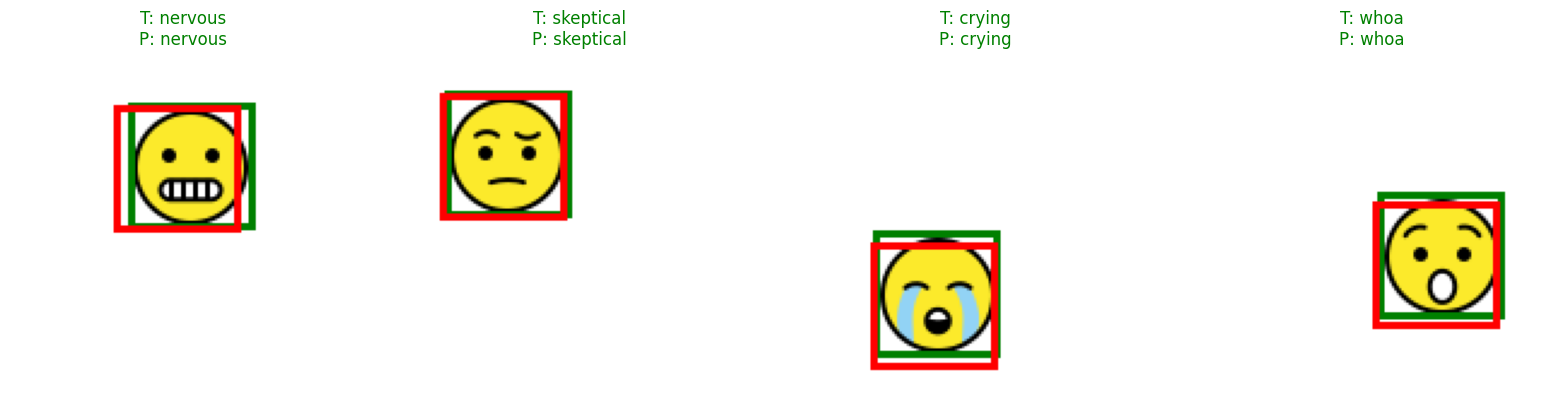

Epoch 16/50 - Validation: 100%|██████████| 100/100 [00:01<00:00, 75.89it/s]



Epoch [16/50]
Train Class Loss: 0.0000 | Train Coord Loss: 0.0002 | Train Acc: 1.0000 | Train IoU: 0.8825
Val Class Loss: 0.0000 | Val Coord Loss: 0.0002 | Val Acc: 1.0000 | Val IoU: 0.8965


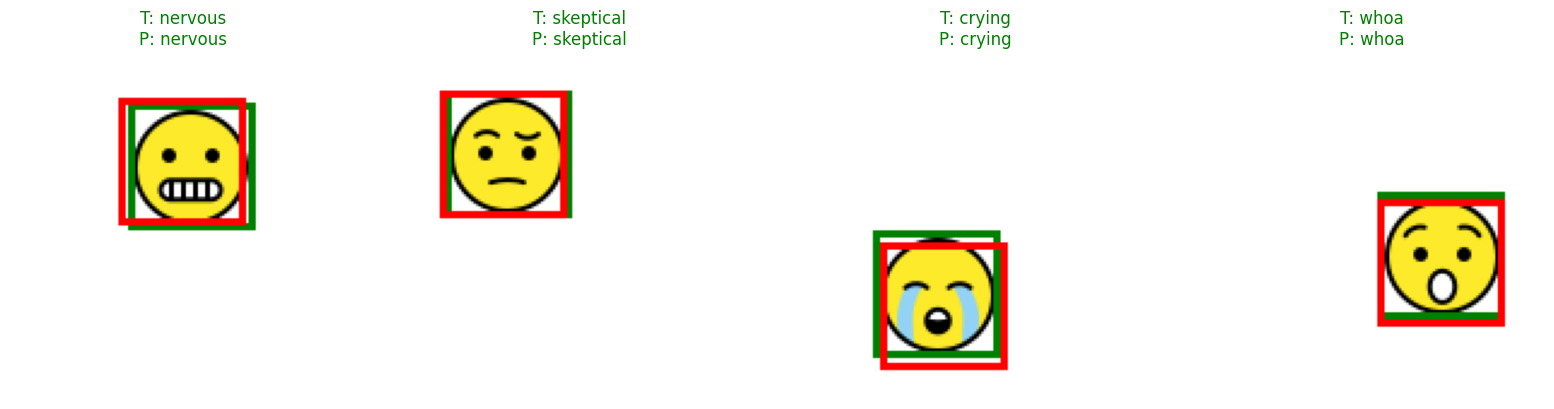

Epoch 17/50 - Validation: 100%|██████████| 100/100 [00:01<00:00, 56.76it/s]


Epoch [17/50]
Train Class Loss: 0.0480 | Train Coord Loss: 0.0006 | Train Acc: 0.9928 | Train IoU: 0.8412
Val Class Loss: 28.7753 | Val Coord Loss: 0.0216 | Val Acc: 0.5863 | Val IoU: 0.4568


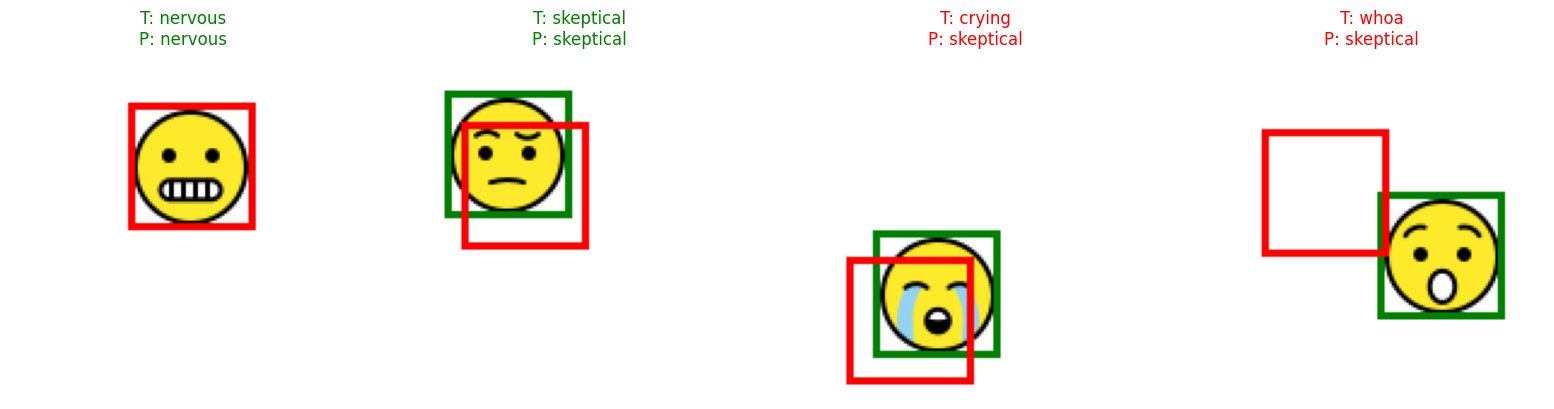

Epoch 18/50 - Validation: 100%|██████████| 100/100 [00:01<00:00, 56.15it/s]


Epoch [18/50]
Train Class Loss: 0.0062 | Train Coord Loss: 0.0007 | Train Acc: 0.9981 | Train IoU: 0.8076
Val Class Loss: 0.0020 | Val Coord Loss: 0.0005 | Val Acc: 0.9994 | Val IoU: 0.8310


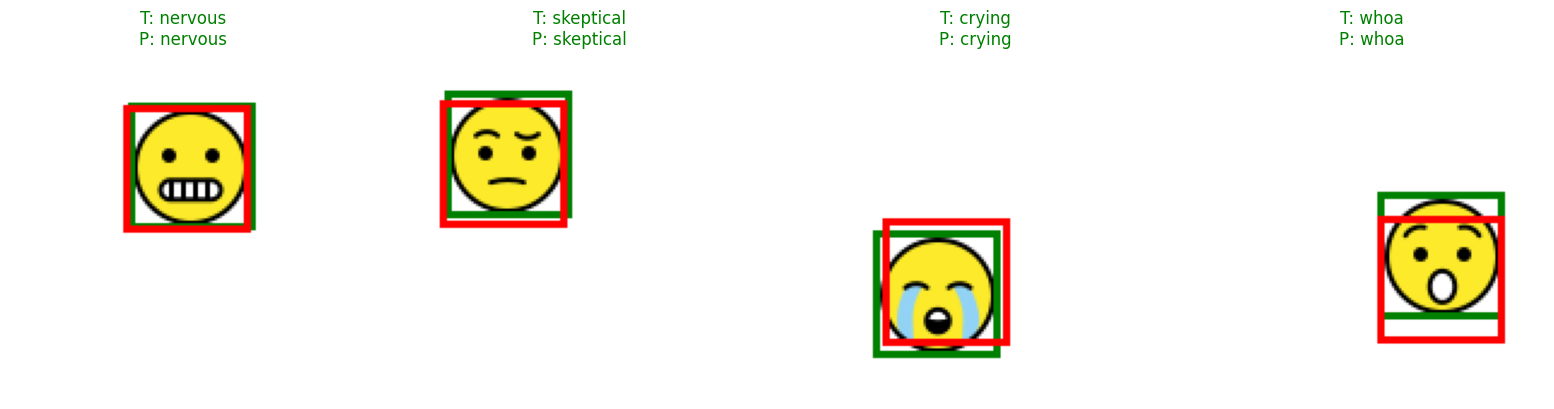

Epoch 19/50 - Validation: 100%|██████████| 100/100 [00:01<00:00, 78.04it/s]


Epoch [19/50]
Train Class Loss: 0.0178 | Train Coord Loss: 0.0006 | Train Acc: 0.9962 | Train IoU: 0.8159
Val Class Loss: 0.0007 | Val Coord Loss: 0.0006 | Val Acc: 1.0000 | Val IoU: 0.8190


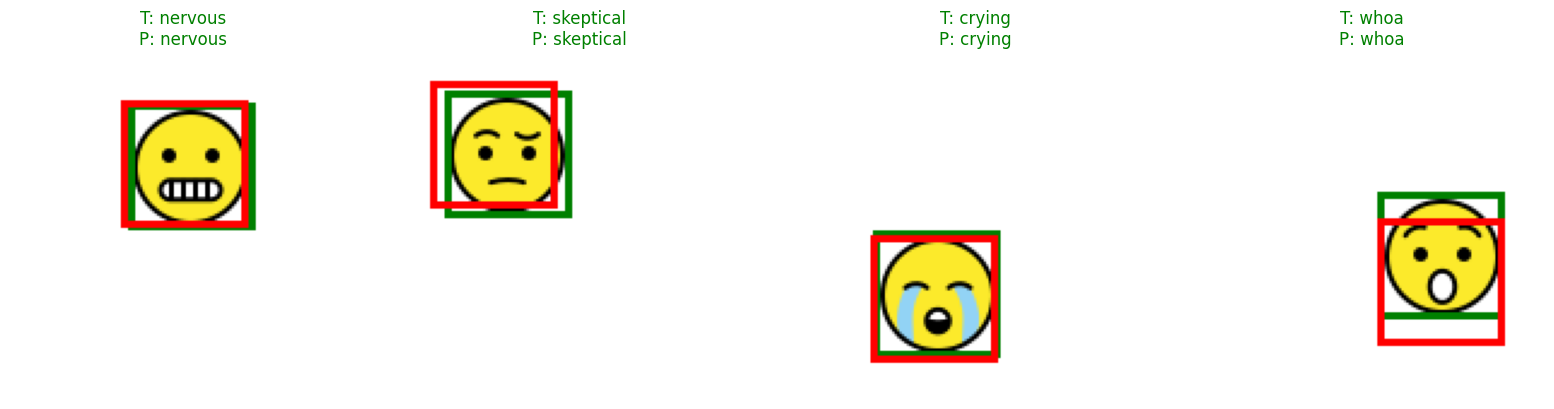

Epoch 20/50 - Validation: 100%|██████████| 100/100 [00:01<00:00, 76.14it/s]


Epoch [20/50]
Train Class Loss: 0.0068 | Train Coord Loss: 0.0005 | Train Acc: 0.9986 | Train IoU: 0.8337
Val Class Loss: 0.0000 | Val Coord Loss: 0.0006 | Val Acc: 1.0000 | Val IoU: 0.8135


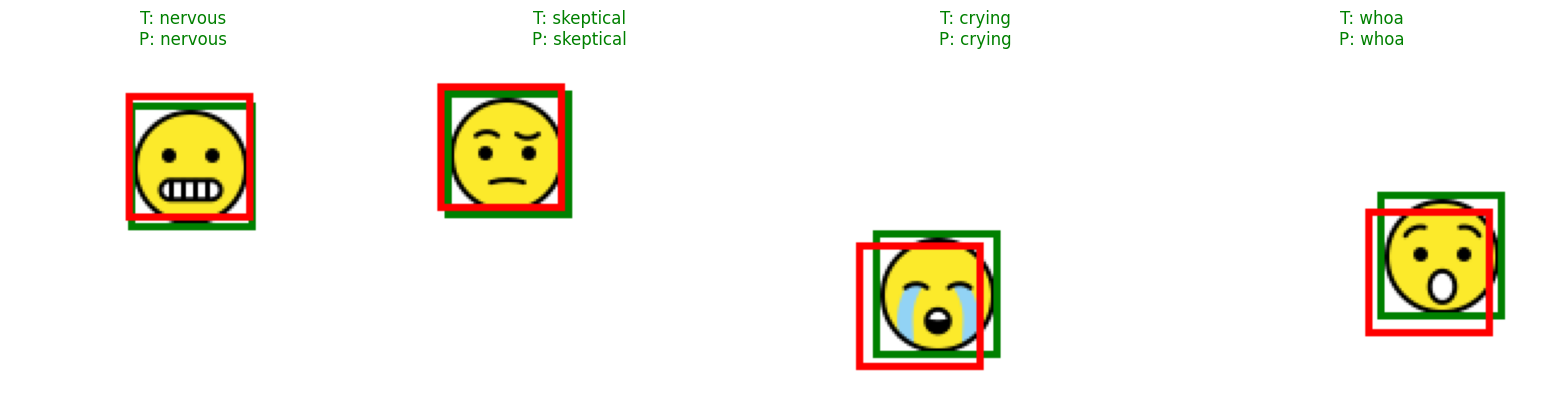

Epoch 21/50 - Validation: 100%|██████████| 100/100 [00:01<00:00, 78.10it/s]



Epoch [21/50]
Train Class Loss: 0.0050 | Train Coord Loss: 0.0004 | Train Acc: 0.9988 | Train IoU: 0.8481
Val Class Loss: 0.0000 | Val Coord Loss: 0.0003 | Val Acc: 1.0000 | Val IoU: 0.8721


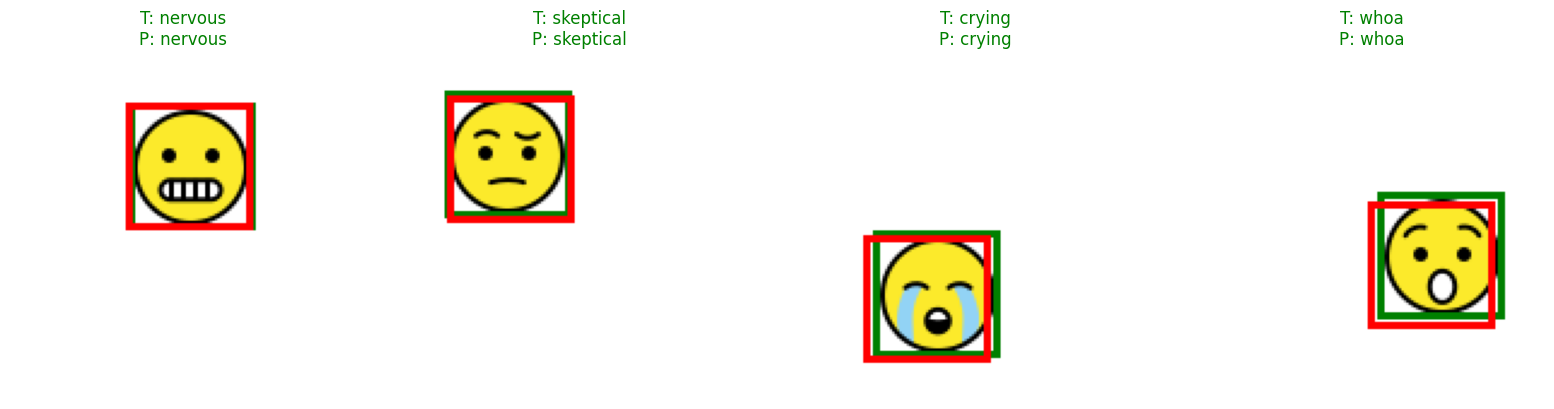

Epoch 22/50 - Validation: 100%|██████████| 100/100 [00:01<00:00, 77.75it/s]


Epoch [22/50]
Train Class Loss: 0.0163 | Train Coord Loss: 0.0004 | Train Acc: 0.9973 | Train IoU: 0.8449
Val Class Loss: 0.0000 | Val Coord Loss: 0.0004 | Val Acc: 1.0000 | Val IoU: 0.8491


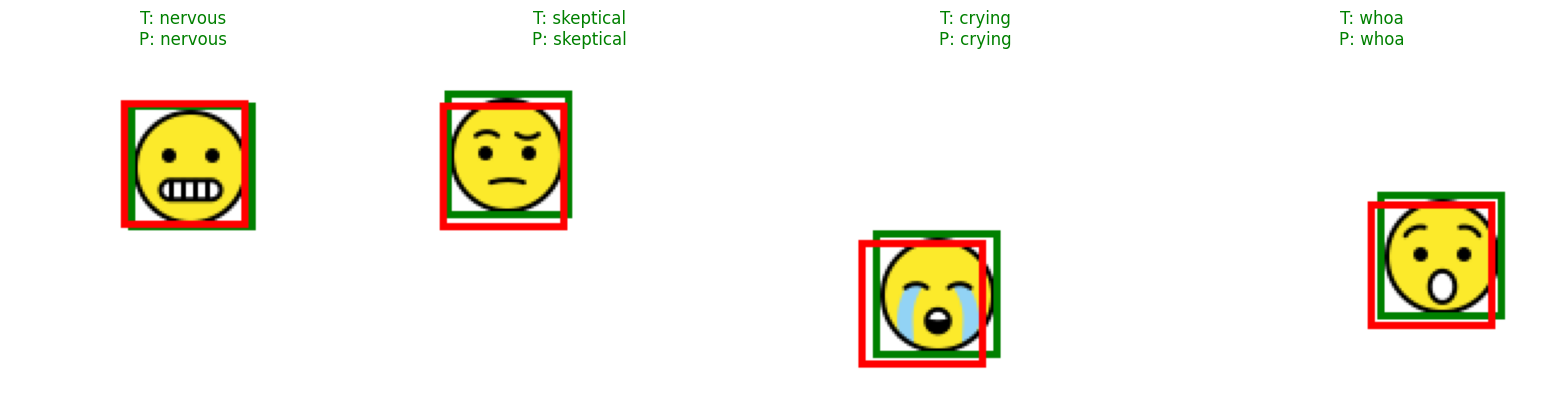

Epoch 23/50 - Validation: 100%|██████████| 100/100 [00:01<00:00, 76.39it/s]


Epoch [23/50]
Train Class Loss: 0.0005 | Train Coord Loss: 0.0003 | Train Acc: 0.9998 | Train IoU: 0.8606
Val Class Loss: 0.0017 | Val Coord Loss: 0.0002 | Val Acc: 0.9994 | Val IoU: 0.8832
Early stopping!



<ipython-input-19-6d7fd411e795>:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [ ]:
for epoch in range(num_epochs):
    model.train()
    train_class_loss = 0.0
    train_coord_loss = 0.0
    train_class_correct = 0
    train_iou_metric = IoU()

    for images_batch, class_labels_batch, coord_labels_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images_batch = images_batch.to(device)
        class_labels_batch = class_labels_batch.to(device)
        coord_labels_batch = coord_labels_batch.to(device)

        optimizer_shared.zero_grad()
        optimizer_class.zero_grad()

        outputs_class, _ = model(images_batch)
        loss_class = criterion_class(outputs_class, class_labels_batch)
        loss_class.backward()
        optimizer_shared.step()
        optimizer_class.step()

        optimizer_shared.zero_grad()
        optimizer_coord.zero_grad()

        _, outputs_coord = model(images_batch)
        loss_coord = criterion_coord(outputs_coord, coord_labels_batch)
        loss_coord.backward()
        optimizer_shared.step()
        optimizer_coord.step()

        train_class_loss += loss_class.item() * images_batch.size(0)
        train_coord_loss += loss_coord.item() * images_batch.size(0)

        preds = torch.argmax(outputs_class, dim=1)
        train_class_correct += (preds == class_labels_batch).sum().item()

        train_iou_metric.update(coord_labels_batch, outputs_coord)

    total_train_sample = int(NUM_SAMPLES * TRAIN_SPLIT)
    epoch_class_loss = train_class_loss / total_train_sample
    epoch_coord_loss = train_coord_loss / total_train_sample
    epoch_class_acc = train_class_correct / total_train_sample
    epoch_iou = train_iou_metric.compute()

    model.eval()
    val_class_loss = 0.0
    val_coord_loss = 0.0
    val_class_correct = 0
    val_iou_metric = IoU()

    with torch.no_grad():
        for images_batch, class_labels_batch, coord_labels_batch in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images_batch = images_batch.to(device)
            class_labels_batch = class_labels_batch.to(device)
            coord_labels_batch = coord_labels_batch.to(device)


            outputs_class, _ = model(images_batch)
            loss_class = criterion_class(outputs_class, class_labels_batch)


            _, outputs_coord = model(images_batch)
            loss_coord = criterion_coord(outputs_coord, coord_labels_batch)

            val_class_loss += loss_class.item() * images_batch.size(0)
            val_coord_loss += loss_coord.item() * images_batch.size(0)

            preds = torch.argmax(outputs_class, dim=1)
            val_class_correct += (preds == class_labels_batch).sum().item()

            val_iou_metric.update(coord_labels_batch, outputs_coord)

    total_val_sample = NUM_SAMPLES - total_train_sample
    val_epoch_class_loss = val_class_loss / total_val_sample
    val_epoch_coord_loss = val_coord_loss / total_val_sample
    val_epoch_class_acc = val_class_correct / total_val_sample
    val_epoch_iou = val_iou_metric.compute()

    scheduler_class.step(val_epoch_class_acc)
    scheduler_coord.step(val_epoch_iou)

    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print(f"Train Class Loss: {epoch_class_loss:.4f} | Train Coord Loss: {epoch_coord_loss:.4f} | Train Acc: {epoch_class_acc:.4f} | Train IoU: {epoch_iou:.4f}")
    print(f"Val Class Loss: {val_epoch_class_loss:.4f} | Val Coord Loss: {val_epoch_coord_loss:.4f} | Val Acc: {val_epoch_class_acc:.4f} | Val IoU: {val_epoch_iou:.4f}")


    if val_epoch_iou > best_val_iou:
        best_val_iou = val_epoch_iou
        epochs_no_improve = 0

        torch.save(model.state_dict(), 'best_model.pth')

    elif val_epoch_class_acc > best_val_acc:
        best_val_acc = val_epoch_class_acc
        epochs_no_improve = 0

        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop_patience:
            print("Early stopping!")
            break


    visualize_predictions(model, test_loader, emojis, device, num_samples=4)


model.load_state_dict(torch.load('best_model.pth'))

# Visualize Results

Evaluating on Test Set: 100%|██████████| 100/100 [00:01<00:00, 82.75it/s]



Test Results:
Test Class Loss: 0.0000
Test Coord Loss (MSE): 0.0002
Test Class Accuracy: 1.0000
Test Coord IoU: 0.8965


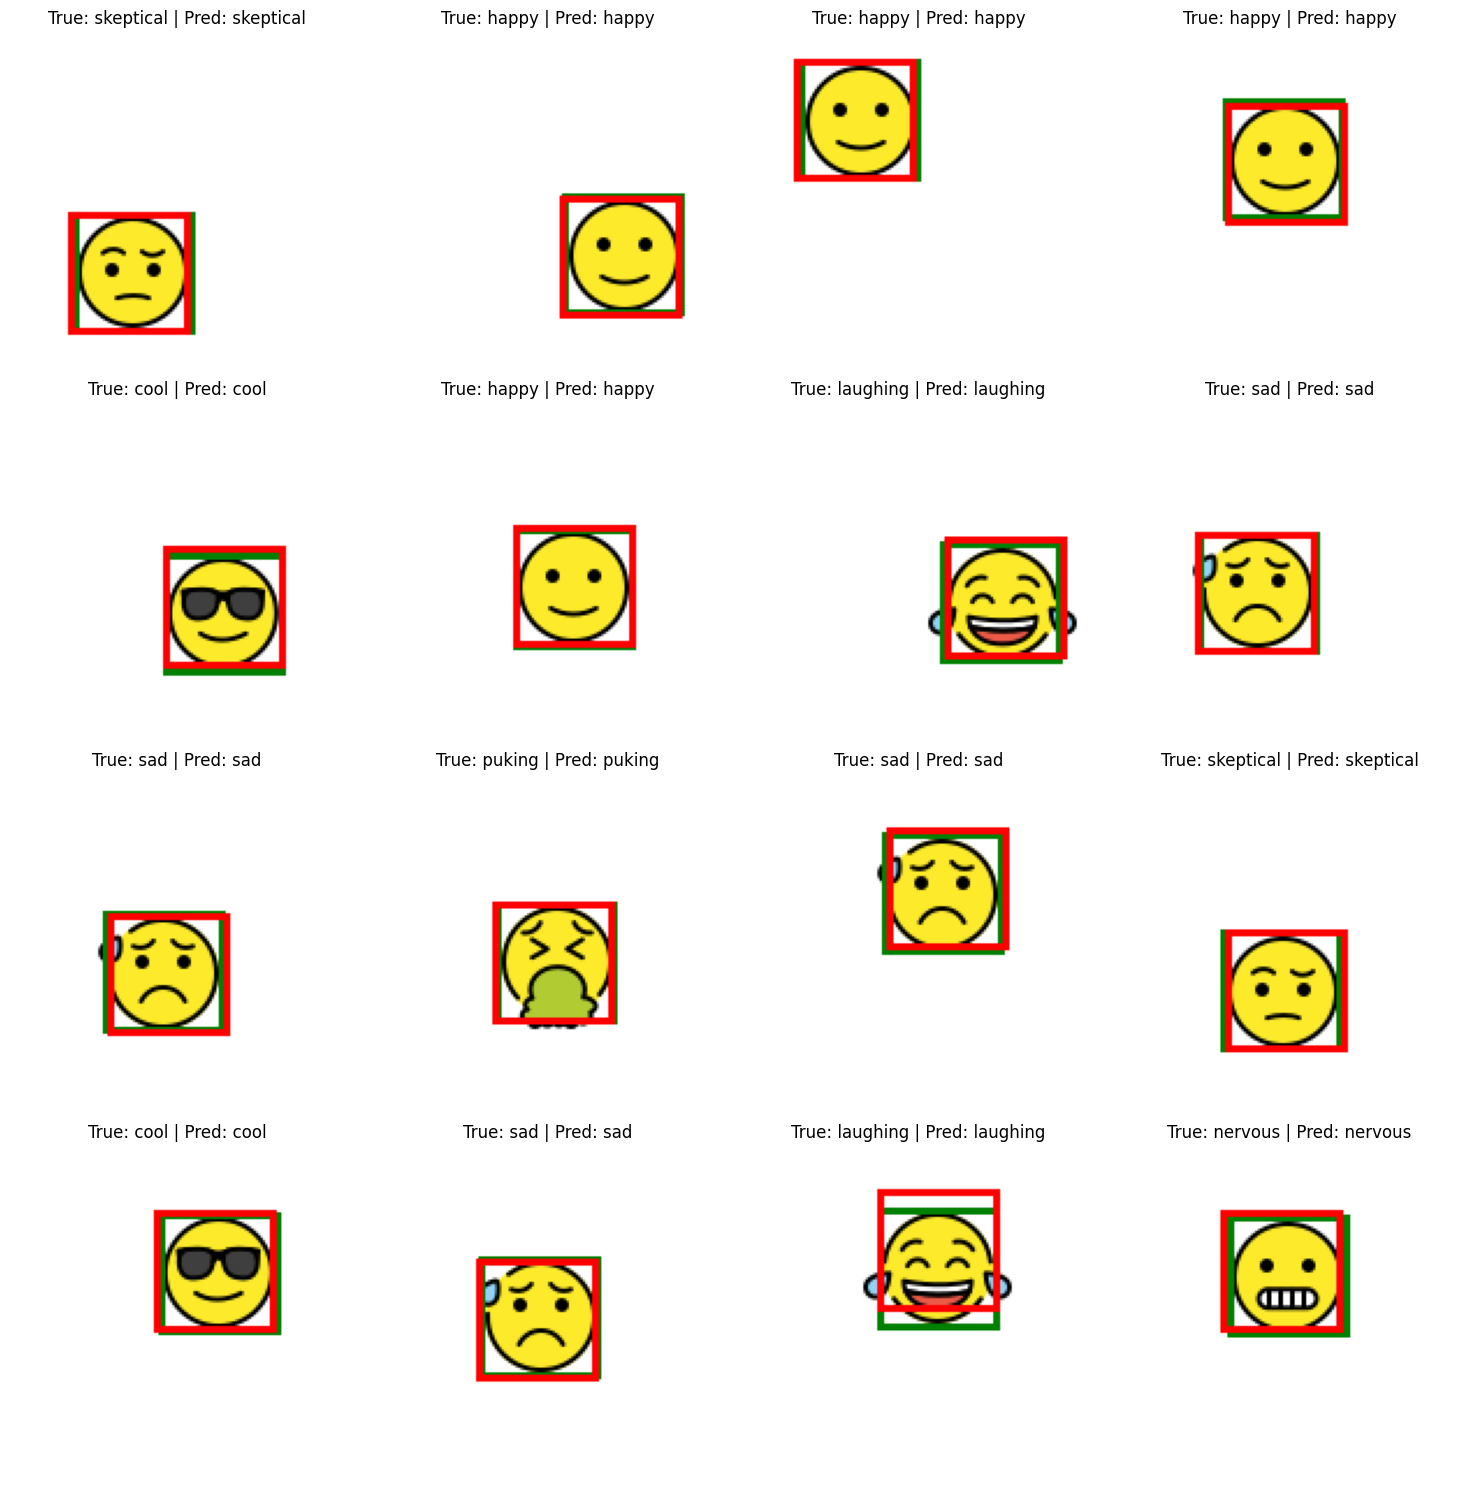

In [ ]:
model.eval()
test_class_loss = 0.0
test_coord_loss = 0.0
test_class_correct = 0
test_iou_metric = IoU()

with torch.no_grad():
    for images_batch, class_labels_batch, coord_labels_batch in tqdm(test_loader, desc="Evaluating on Test Set"):
        images_batch = images_batch.to(device)
        class_labels_batch = class_labels_batch.to(device)
        coord_labels_batch = coord_labels_batch.to(device)

        outputs_class, _ = model(images_batch)
        loss_class = criterion_class(outputs_class, class_labels_batch)

        _, outputs_coord = model(images_batch)
        loss_coord = criterion_coord(outputs_coord, coord_labels_batch)

        test_class_loss += loss_class.item() * images_batch.size(0)
        test_coord_loss += loss_coord.item() * images_batch.size(0)

        preds = torch.argmax(outputs_class, dim=1)
        test_class_correct += (preds == class_labels_batch).sum().item()

        test_iou_metric.update(coord_labels_batch, outputs_coord)

test_epoch_class_loss = test_class_loss / len(test_dataset)
test_epoch_coord_loss = test_coord_loss / len(test_dataset)
test_epoch_class_acc = test_class_correct / len(test_dataset)
test_epoch_iou = test_iou_metric.compute()

print("\nTest Results:")
print(f"Test Class Loss: {test_epoch_class_loss:.4f}")
print(f"Test Coord Loss (MSE): {test_epoch_coord_loss:.4f}")
print(f"Test Class Accuracy: {test_epoch_class_acc:.4f}")
print(f"Test Coord IoU: {test_epoch_iou:.4f}")

def visualize_test_predictions(model, dataset, emojis, device, num_visualize=9):
    model.eval()
    indices = random.sample(range(len(dataset)), num_visualize)
    samples = [dataset[i] for i in indices]
    images, class_labels, coord_labels = zip(*samples)

    images = torch.stack(images).to(device)
    class_labels = torch.stack(class_labels).to(device)
    coord_labels = torch.stack(coord_labels).to(device)

    with torch.no_grad():
        class_preds, coord_preds = model(images)
        class_pred_labels = torch.argmax(class_preds, dim=1)

    images = images.cpu().numpy().transpose(0, 2, 3, 1)
    class_labels = class_labels.cpu().numpy()
    class_pred_labels = class_pred_labels.cpu().numpy()
    coord_labels = coord_labels.cpu().numpy()
    coord_preds = coord_preds.cpu().numpy()

    plt.figure(figsize=(15, 15))
    for i in range(num_visualize):
        img = (images[i] * 255).astype('uint8')
        true_class = class_labels[i]
        pred_class = class_pred_labels[i]
        true_coord = coord_labels[i]
        pred_coord = coord_preds[i]

        img_with_boxes = plot_bounding_box(img, gt_coords=true_coord, pred_coords=pred_coord, norm=True)

        plt.subplot(4, 4, i+1)
        plt.imshow(img_with_boxes)
        plt.title(f"True: {emojis[true_class]['name']} | Pred: {emojis[pred_class]['name']}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_test_predictions(model, test_dataset, emojis, device, num_visualize=16)